# Thermal Radiation 
ESE 156, Christian Frankenberg

This notebook will provide a quick intro into thermal radiation, the Planck curve and how to solve a non-scattering thermal RT problem using a layered atmosphere (and ignoring surface emissivity $<$1 for now).

In [1]:
## Make sure plots are create inline
%matplotlib inline
## The usual packages (numpy, matplotlib, etc)
from RSE_style import *
from scipy.ndimage.filters import gaussian_filter1d

In [2]:
figsize(10,6)

### Planck Curve
Here, we need to define the blackbody radiation as a function of wavelength and Temperature. The equation for total outgoing radiance as a function of wavelength wavelength would be
$$B_\lambda(T)\mathrm{d}\lambda = \frac{2 h c^2}{\lambda^5}\frac{1}{e^{\frac{hc}{\lambda k_BT}}-1}\mathrm{d}\lambda\,$$
with $k_B$ being the Boltzmann constant, $h$ the Planck constant, and c the speed of light. Here, $B_\lambda(T)$ is described in terms of the power (W) emitted per unit area of the body, per unit solid angle (sr) that the radiation is measured over, per unit frequency (in SI unit of meters here, we will need to convert to get to nm or $\mu$m). For the sun, we will want to look at the total radiation emitted at the sun's surface, for which we just have to integrate across all solid angles in one hemisphere, effectively mulitplying by $\pi$.  

Similarly, if we are looking at solar irradiance at the top of the Earth's atmosphere, we need to take the distance between the sun and the earth into account. We do so by computing the ratio of the sphere area with radius of sun-earth distance (1AU) and the surface area of the sun. The radius of the sun is about 695,700km. The distance between the centers of sun and earth is 1 Astronomical Unit (AU), i.e. 149,597,870.7km. The ratio of the distances (sun center to sun surface vs sun center to earth surface) is thus (149597870.7-6300)/695700=215.02. Thus, we have to divide the solar irradiance at the sun's surface by 215.02$^2$ to get to the fluxes at the extended distance. The conversion factor is about 2.1629e-05. 
___________
 First, we need to actually define the Planck function. Easiest done via a function definition in python (which can be exported to a separate file and them imported for use but here we define it within the code):


In [3]:
# Some constants and the planck function (as radiance!)
pi = np.pi
h = 6.626e-34
c = 299792458
k = 1.38e-23

def planck(wav, T):
    c1 = 2.0*h*c**2
    c2 = h*c/(wav*k*T)
    intensity = c1/ ( (wav**5)*(np.exp(c2) - 1.0) )
    # Convert to W/sr/m^2/µm here directly (it was W/sr/m^2/m)
    return intensity*1.e-6


In the above definition, you can either define wavelength or Temperature as vector (the other as scalar) but not both. 

In [4]:
# Define some variables + wavelength grid:

# Ratio of solar Radius to 1AU (squared):
sunEarth = 2.1629e-05

# Effective temperature of the sun in K
Tsun = 5800.0
Tsun2 = 6000.0

# Define a wavelengths grid (equation demands SI unit of meters).
wl = np.arange(150,35000,10)*1e-9

### Compute a solar spectrum (and compare against a measured one)

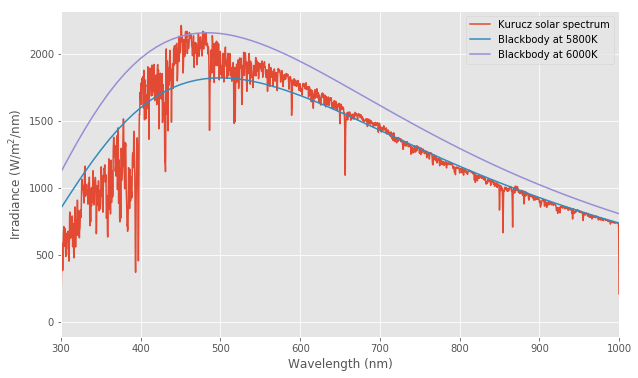

In [5]:
# Load in a measured solar spectrum (up to 1µm):
solar_irr = np.loadtxt('../Week5/data/irradthuwl.br_5nmresamp')
plt.plot(solar_irr[:,0], solar_irr[:,1]*1e3,label='Kurucz solar spectrum')
plt.plot(wl*1e9, planck(wl,Tsun)*sunEarth*np.pi, label='Blackbody at 5800K')
plt.plot(wl*1e9, planck(wl,Tsun2)*sunEarth*np.pi, label='Blackbody at 6000K')
plt.ylabel('Irradiance (W/m$^2$/nm)')
plt.xlabel('Wavelength (nm)')
plt.xlim((300,1000))
plt.legend()

Text(0.5,1,'Outgoing radiation at the top of atmosphere (ignoring the Earth atmosphere)')

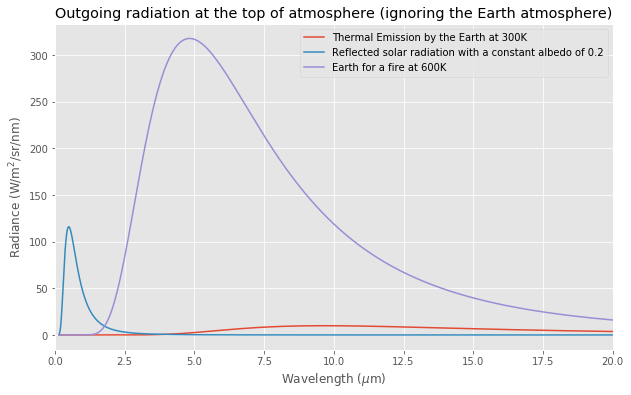

In [6]:
plt.plot(wl*1e6, planck(wl,300),wl*1e6, planck(wl,Tsun)*sunEarth*0.2)
plt.plot(wl*1e6, planck(wl,600))
plt.xlim((0,20))
plt.legend(['Thermal Emission by the Earth at 300K','Reflected solar radiation with a constant albedo of 0.2','Earth for a fire at 600K'])
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Radiance (W/m$^2$/sr/nm)')
plt.title('Outgoing radiation at the top of atmosphere (ignoring the Earth atmosphere)')

A very useful sanity check is always to look at the absolute numbers and see whether they make sense. If we want to integrate the numbers over the solid angle (just multiply by $\pi$) and the frequencies, we should actually get the solar constant (1370W/m$^2$) and the total thermal emission from the Earth surface:
$$F(T) = \pi \int_0^\infty B_\lambda(T) d\lambda $$ 
$$F(T) \approx \pi \sum_{i=0}^n B(T,\lambda_i)  \Delta \lambda $$

In [7]:
print('Integral of outgoing radiation at 288K: '+ str(pi*np.sum(planck(wl,288)/100.)) +  ' W/m2')
print('Integral of outgoing radiation at 262K: ' + str(pi*np.sum(planck(wl,262)/100.)) + ' W/m2')
print('Integral of solar radiation at TOA: ' + str(pi*np.sum(planck(wl,Tsun)*sunEarth/100)) + ' W/m2')
print('Integral of outgoing radiation at 600K: ' + str(pi*np.sum(planck(wl,600)/100.)) + ' W/m2')

Integral of outgoing radiation at 288K: 356.5426019027673 W/m2
Integral of outgoing radiation at 262K: 238.56408745536262 W/m2
Integral of solar radiation at TOA: 1385.2722090131447 W/m2
Integral of outgoing radiation at 600K: 7242.272729223912 W/m2


That looks about right, the integral for the solar part is very close to the solar constant of 1365W/m$^2$. The average TOA flux is one quarter of the solar constant ($(\pi r^2)/(4\pi r^2)$) and so is approximately 340 W/m$^2$.

<img src="EnergyBudget.jpg">

With an effective albedo of about 0.29 (mix of cloud and surface albedo), the net absorbed SW radiation is around $(1-albedo)\cdot 340=241W/m^2$. Without an atmosphere, we would only need a surface temperature of around 262K to achieve Energy Balance (see above calculation). The discrepancy is really the natural greenhouse gas effect, which is why Earth is actually habitable. 

Text(0.5,1,'Earth Emission spectrum')

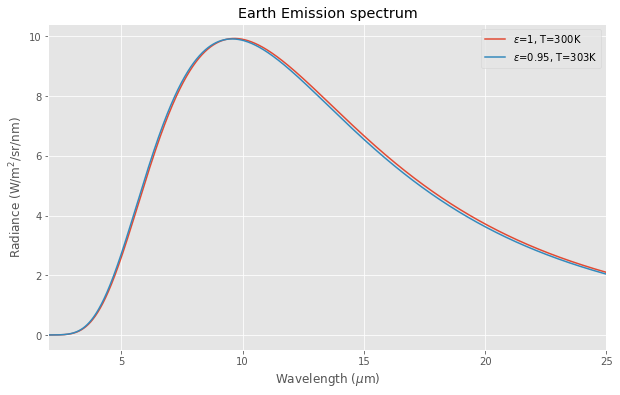

In [8]:
plt.plot(wl*1e6, planck(wl,300), label='$\epsilon$=1, T=300K')
plt.plot(wl*1e6, 0.95*planck(wl,303), label='$\epsilon$=0.95, T=303K')
plt.xlim((2,25))
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Radiance (W/m$^2$/sr/nm)')
plt.legend()
plt.title('Earth Emission spectrum')

Text(0.5,1,'Cumulative Energy Distribution in LW')

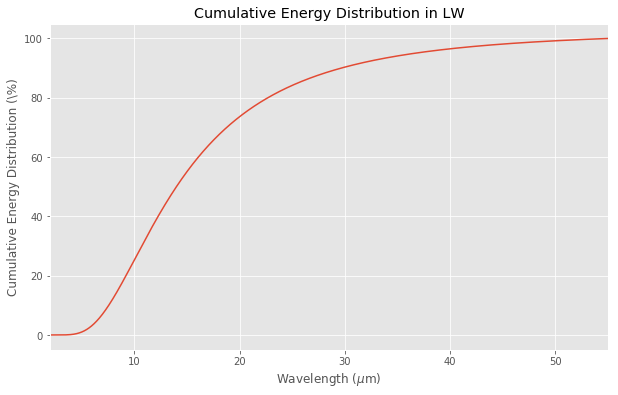

In [9]:
wl2 = np.arange(150,55000,10)*1e-9
earthSpec = (planck(wl2,288)/100.)*pi
plt.plot(wl2*1e6, 100*np.cumsum(earthSpec)/np.sum(earthSpec))
plt.xlim((2,55))
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Cumulative Energy Distribution (\%)')
plt.title('Cumulative Energy Distribution in LW')

Text(0.5,1,'Cumulative Energy Distribution in SW')

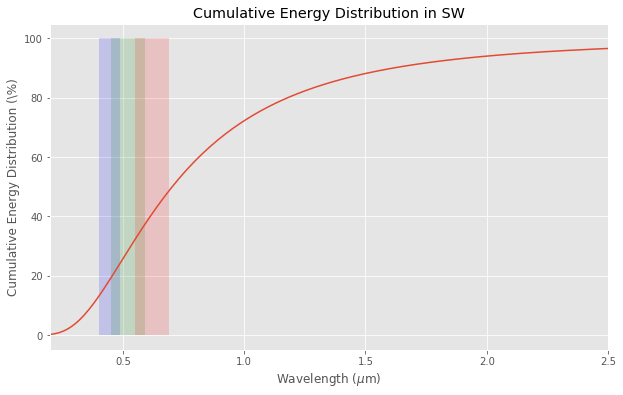

In [10]:
solarSpec = planck(wl,Tsun)*sunEarth/100*pi
plt.plot(wl*1e6, 100*np.cumsum(solarSpec)/np.sum(solarSpec))
x1 = np.arange(0.4, 0.50, 0.01)
x2 = np.arange(0.45, 0.600, 0.01)
x3 = np.arange(0.55, 0.700, 0.01)
plt.fill_between(x1, 0, 100,  facecolor='blue',alpha=0.15)
plt.fill_between(x2, 0, 100,  facecolor='green',alpha=0.15)
plt.fill_between(x3, 0, 100,  facecolor='red',alpha=0.15)
plt.xlim((0.2,2.5))
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Cumulative Energy Distribution (\%)')
plt.title('Cumulative Energy Distribution in SW')

### I pre-computed the optical properties in a separate notebook (getLongWave...) (but ignored O3 for now)
This should be done in a separate function call but you get the gist of it. Computing cross sections takes a long time, so best to prepare a database. Also, we are covering a huge wavenumber range here with about 100k spectral points to compute!!

In [11]:
import h5py as h5
# Open up a file (will be generate if non-existent)
f = h5.File('data/crossSections_LongTropics.h5')
# Save the most important variables we would like to keep:
cs_matrix_co2 = f['CrossSections/cs_matrix_co2'][:]
cs_matrix_ch4=f['CrossSections/cs_matrix_ch4'][:]
cs_matrix_h2o=f['CrossSections/cs_matrix_h2o'][:]
cs_matrix_o3=f['CrossSections/cs_matrix_o3'][:]
VCD_dry=f['Profiles/VCD_dry'][:]
vmr_h2o=f['Profiles/vmr_h2o'][:]
rho_N_h2o = f['Profiles/rho_N_h2o'][:]
nu_=f['wavenumberGrid'][:]
#f['Tsolar']=Tsolar 
p_full=f['Profiles/p'][:]
T_local=f['Profiles/T_local'][:]
dz = f['Profiles/dz'][:]
f.close()
print(T_local)
T_min = np.min(T_local)
NLEV=72

[215.45175 221.40335 224.5431  219.95743 215.73366 217.31238 221.20387
 227.00641 234.92233 243.8359  253.5751  260.9909  262.24326 258.2085
 256.1413  254.96626 257.06635 257.24576 257.38986 251.98483 241.85477
 238.96744 235.38672 231.89325 229.08629 227.99335 226.83029 224.77838
 222.72127 223.99478 222.04071 216.61719 210.27094 206.82071 202.60034
 196.46523 192.1323  195.2988  197.76161 202.69772 208.55043 216.88904
 228.07132 236.07515 245.15187 253.15414 256.37616 261.97125 265.61102
 269.04156 272.48788 275.30875 278.00317 280.25745 282.3849  283.69342
 284.94183 286.1652  287.50256 288.73935 289.7157  290.59616 291.5781
 292.89618 294.0802  294.561   295.2378  296.0117  296.81073 297.7998
 298.40436 297.81555]


In [12]:
figsize(10,6)

Text(0,0.5,'Cross Section (in one layer)')

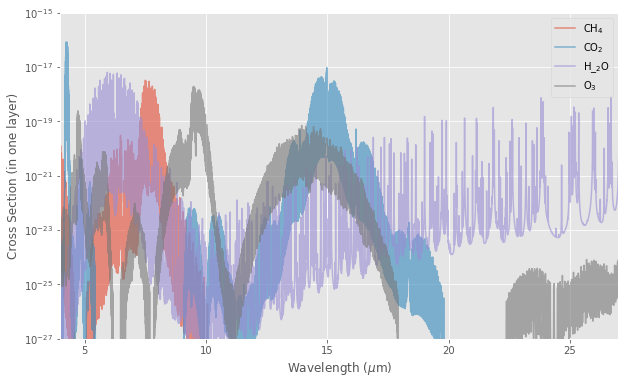

In [13]:
plt.semilogy(1e4/nu_,cs_matrix_ch4[:,40], label='CH$_4$', alpha=0.6)
plt.semilogy(1e4/nu_,cs_matrix_co2[:,40], label='CO$_2$', alpha=0.6)
plt.semilogy(1e4/nu_,cs_matrix_h2o[:,40], label='H_$_2$O', alpha=0.6)
plt.semilogy(1e4/nu_,cs_matrix_o3[:,40], label='O$_3$', alpha=0.6)
plt.legend(loc=0)
plt.xlim((4,27))
plt.ylim((10e-28,10e-16))
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Cross Section (in one layer)')

Text(0.5,1,'Atmospheric transmission (entire column)')

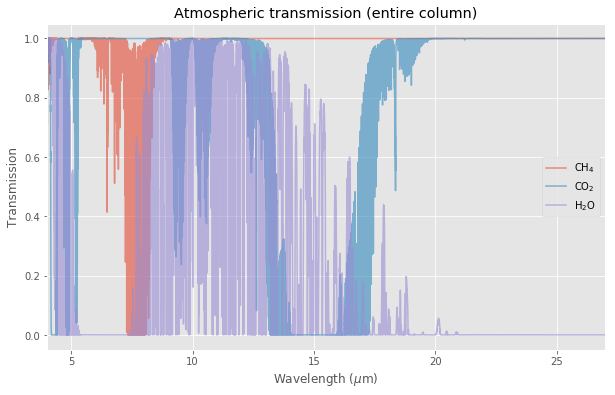

In [14]:
AMF = 1
# Compute transmission for each layer:
T = np.zeros((len(nu_),NLEV))
# Generate matrices of optical thickness per layer now for each gas: 
tau_co2 = cs_matrix_co2*VCD_dry*400.e-6*AMF 
#VCD_h2o = dz*rho_N_h2o
tau_h2o = cs_matrix_h2o*VCD_dry*vmr_h2o*AMF 
tau_ch4 = cs_matrix_ch4*VCD_dry*1.8e-6*AMF 

plt.plot(1e4/nu_,np.exp(-np.sum(tau_ch4,axis=1)), label='CH$_4$', alpha=0.6)
plt.plot(1e4/nu_,np.exp(-np.sum(tau_co2,axis=1)), label='CO$_2$', alpha=0.6)
plt.plot(1e4/nu_,np.exp(-np.sum(tau_h2o,axis=1)), label='H$_2$O', alpha=0.6)

plt.legend(loc=0)
plt.xlim((4,27))
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Transmission')
plt.title('Atmospheric transmission (entire column)')

### Computing Transmissions for each layer
As we have learned before, the thermal contributions from each layer can be fully determined from its Transmission. Here, we are computing Transmissions for each layer and also compute Transmissions for a double CO2, CH4 or H2O concentration!

In [15]:
T = np.exp(-tau_co2)*np.exp(-tau_h2o)*np.exp(-tau_ch4)
TdCO2 = np.exp(-2*tau_co2)*np.exp(-tau_h2o)*np.exp(-tau_ch4)
TdH2O = np.exp(-tau_co2)*np.exp(-2*tau_h2o)*np.exp(-tau_ch4)
TdCH4 = np.exp(-tau_co2)*np.exp(-tau_h2o)*np.exp(-2*tau_ch4)

In [16]:
print(T.shape)

(107501, 72)


Text(0,0.5,'Atmospheric Transmission')

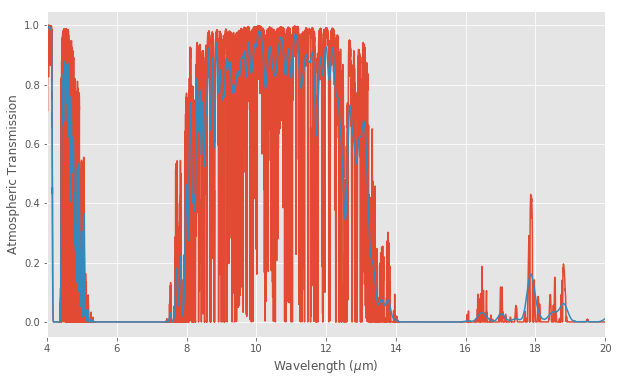

In [17]:
plt.plot(1e7/nu_/1e3,np.prod(T,axis=1))
plt.plot(1e7/nu_/1e3,gaussian_filter1d(np.prod(T,axis=1),150))
#plt.plot(1e7/nu_/1e3,gaussian_filter1d(np.prod(TdH2O,axis=1),150))
plt.xlim((4,20))
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Atmospheric Transmission')

Text(0,0.5,'Atmospheric Transmission')

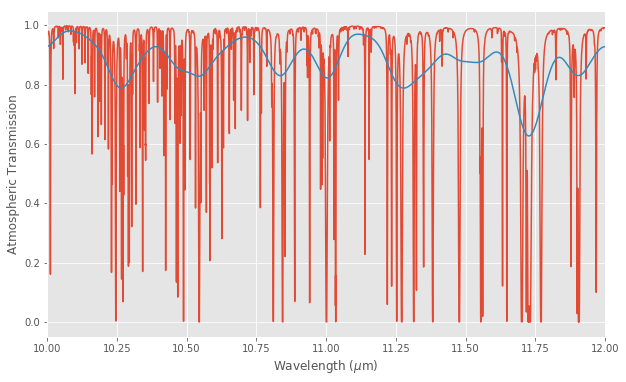

In [18]:
plt.plot(1e7/nu_/1e3,np.prod(T,axis=1))
plt.plot(1e7/nu_/1e3,gaussian_filter1d(np.prod(T,axis=1),150))
#plt.plot(1e7/nu_/1e3,gaussian_filter1d(np.prod(TdH2O,axis=1),150))
plt.xlim((10,12))
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Atmospheric Transmission')

In [19]:
# Generate Planck curve per layer + surface:
wl_nu = 1.e7/nu_*1.e-9
# Use skin temperature of 300K
B_surf = planck(wl_nu,300)
B = np.zeros((len(nu_),NLEV))
for i in range(NLEV):
    B[:,i] = planck(wl_nu,T_local[i])

Text(0,0.5,'outgoing Radiance (W/m$^2$/sr/nm)')

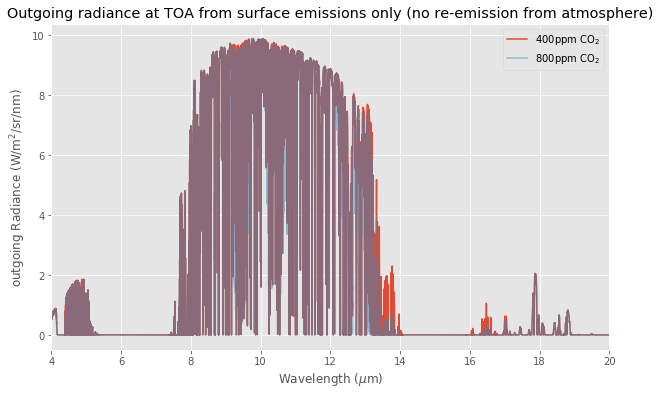

In [20]:
R_surf = np.prod(T,axis=1)*B_surf
R_surfDCO2 = np.prod(TdCO2,axis=1)*B_surf
R_surfDCH4 = np.prod(TdCH4,axis=1)*B_surf
R_surfDH2O = np.prod(TdH2O,axis=1)*B_surf
R_surf_900 = np.prod(T[:,65:],axis=1)*B_surf
plt.plot(wl_nu*1e6,R_surf,label='400ppm CO$_2$')
plt.plot(wl_nu*1e6,R_surfDCO2, alpha=0.5,label='800ppm CO$_2$')
plt.xlim((4,20))
plt.legend(loc=0)
plt.title('Outgoing radiance at TOA from surface emissions only (no re-emission from atmosphere)')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('outgoing Radiance (W/m$^2$/sr/nm)')

## Break here, how do we compute radiation within the atmosphere now?? (whiteboard)

Let us compute the contribution to the TOA radiance from each atmospheric layer. You should be able to figure out where these equations come from by now. Can you?

In [21]:
R = np.zeros((len(nu_),NLEV))
R_dCO2 = np.zeros((len(nu_),NLEV))
R_dCH4 = np.zeros((len(nu_),NLEV))
R_dH2O = np.zeros((len(nu_),NLEV))
print(p_full[65])
R_900hPa = np.zeros((len(nu_),NLEV-65))
for i in range(NLEV):
    R[:,i] = B[:,i]*(1-T[:,i])*np.prod(T[:,0:i],axis=1)
    R_dCO2[:,i] = B[:,i]*(1-TdCO2[:,i])*np.prod(TdCO2[:,0:i],axis=1)
    R_dCH4[:,i] = B[:,i]*(1-TdCH4[:,i])*np.prod(TdCH4[:,0:i],axis=1)
    R_dH2O[:,i] = B[:,i]*(1-TdH2O[:,i])*np.prod(TdH2O[:,0:i],axis=1)
for i in range(NLEV-65):
 #   print(i,np.prod(T[:,65:i+65],axis=1) )
    R_900hPa[:,i] = B[:,i+65]*(1-T[:,i+65])*np.prod(T[:,65:i+65],axis=1)

#plt.plot(wl_nu*1e6,B[:,65]*(1-T[:,65])*np.prod(T[:,0:64],axis=1))

908.2328


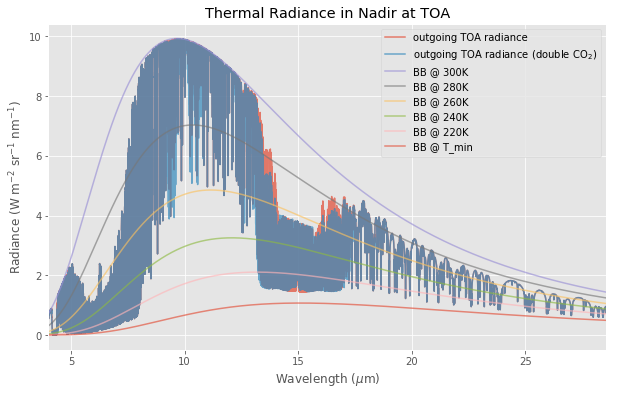

In [22]:
figsize(10,6)
from scipy.ndimage.filters import gaussian_filter1d
TOA = np.sum(R,axis=1)+R_surf
TOA_dCO2 = np.sum(R_dCO2,axis=1)+R_surfDCO2
#TOA = gaussian_filter1d(TOA, 5)
plt.plot(wl_nu*1e6,TOA,label='outgoing TOA radiance', alpha=0.7)
plt.plot(wl_nu*1e6,TOA_dCO2,label='outgoing TOA radiance (double CO$_2$)', alpha=0.7)#, wl_nu*1e6, np.sum(R,axis=1), wl_nu*1e6,R_surf)
#plt.plot(wl_nu*1e6, planck(wl_nu,310),label='BB @ 310K',alpha=0.63)
plt.plot(wl_nu*1e6, planck(wl_nu,300),label='BB @ 300K',alpha=0.63)
plt.plot(wl_nu*1e6, planck(wl_nu,280),label='BB @ 280K',alpha=0.63)
plt.plot(wl_nu*1e6, planck(wl_nu,260),label='BB @ 260K',alpha=0.63)
plt.plot(wl_nu*1e6, planck(wl_nu,240),label='BB @ 240K',alpha=0.63)
plt.plot(wl_nu*1e6, planck(wl_nu,220),label='BB @ 220K',alpha=0.63)
plt.plot(wl_nu*1e6, planck(wl_nu,T_min),label='BB @ T_min',alpha=0.63)
plt.legend(loc=0)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Radiance (W m$^{-2}$ sr$^{-1}$ nm$^{-1}$)')
plt.xlim((wl_nu[-1]*1e6,wl_nu[0]*1e6))
plt.title('Thermal Radiance in Nadir at TOA')
plt.savefig('ThermalTAO.pdf')

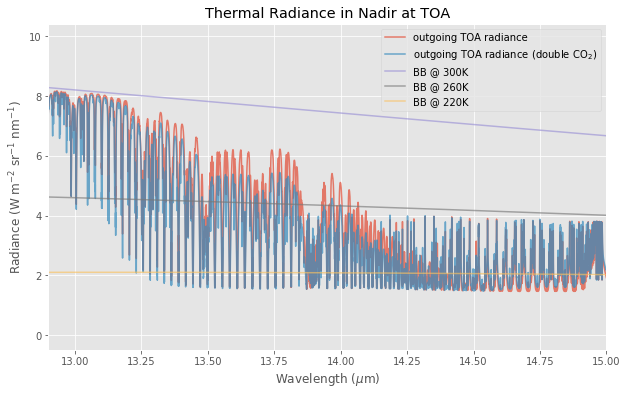

In [23]:
plt.plot(wl_nu*1e6,TOA,label='outgoing TOA radiance', alpha=0.7)
plt.plot(wl_nu*1e6,TOA_dCO2,label='outgoing TOA radiance (double CO$_2$)', alpha=0.7)#, wl_nu*1e6, np.sum(R,axis=1), wl_nu*1e6,R_surf)
#plt.plot(wl_nu*1e6, planck(wl_nu,310),label='BB @ 310K',alpha=0.63)
plt.plot(wl_nu*1e6, planck(wl_nu,300),label='BB @ 300K',alpha=0.63)
#plt.plot(wl_nu*1e6, planck(wl_nu,280),label='BB @ 280K',alpha=0.63)
plt.plot(wl_nu*1e6, planck(wl_nu,260),label='BB @ 260K',alpha=0.63)
#plt.plot(wl_nu*1e6, planck(wl_nu,240),label='BB @ 240K',alpha=0.63)
plt.plot(wl_nu*1e6, planck(wl_nu,220),label='BB @ 220K',alpha=0.63)
plt.legend(loc=0)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Radiance (W m$^{-2}$ sr$^{-1}$ nm$^{-1}$)')
plt.xlim((12.9,15))
plt.title('Thermal Radiance in Nadir at TOA')
plt.savefig('ThermalTAO_zoom_co2Band.pdf')

Text(0.5,1,'Thermal Radiance in Nadir at TOA')

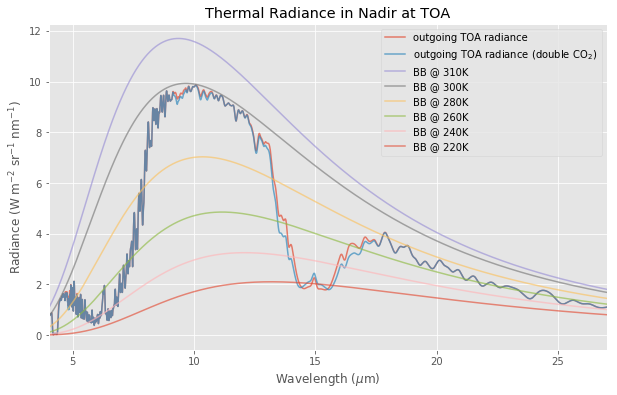

In [24]:
from scipy.ndimage.filters import gaussian_filter1d
plt.plot(wl_nu*1e6,gaussian_filter1d(TOA,150),label='outgoing TOA radiance', alpha=0.7)
plt.plot(wl_nu*1e6,gaussian_filter1d(TOA_dCO2,150),label='outgoing TOA radiance (double CO$_2$)', alpha=0.7)
plt.plot(wl_nu*1e6, planck(wl_nu,310),label='BB @ 310K',alpha=0.63)
plt.plot(wl_nu*1e6, planck(wl_nu,300),label='BB @ 300K',alpha=0.63)
plt.plot(wl_nu*1e6, planck(wl_nu,280),label='BB @ 280K',alpha=0.63)
plt.plot(wl_nu*1e6, planck(wl_nu,260),label='BB @ 260K',alpha=0.63)
plt.plot(wl_nu*1e6, planck(wl_nu,240),label='BB @ 240K',alpha=0.63)
plt.plot(wl_nu*1e6, planck(wl_nu,220),label='BB @ 220K',alpha=0.63)
plt.legend(loc=0)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('Radiance (W m$^{-2}$ sr$^{-1}$ nm$^{-1}$)')
plt.xlim((4,27))
plt.title('Thermal Radiance in Nadir at TOA')

Text(0.5,1,'Thermal Radiance in Nadir at TOA, change due to CO2')

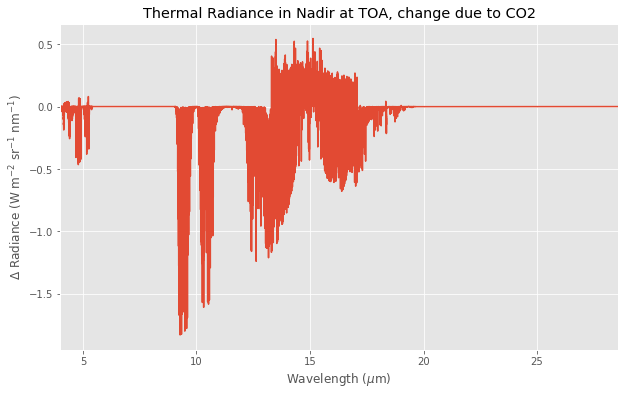

In [25]:
plt.plot(wl_nu*1e6,TOA_dCO2-TOA,label='$\Delta$ in outgoing TOA radiance for CO2 doubling')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('$\Delta$ Radiance (W m$^{-2}$ sr$^{-1}$ nm$^{-1}$)')
plt.xlim((wl_nu[-1]*1e6,wl_nu[0]*1e6))
plt.title('Thermal Radiance in Nadir at TOA, change due to CO2')
#plt.plot(wl_nu*1e6,TOA_dCO2,label='outgoing TOA radiance (double CO$_2$)', alpha=0.7)#, wl_nu*1e6, np.sum(R,axis=1), wl_nu*1e6,R_surf)

1.2763866174522258


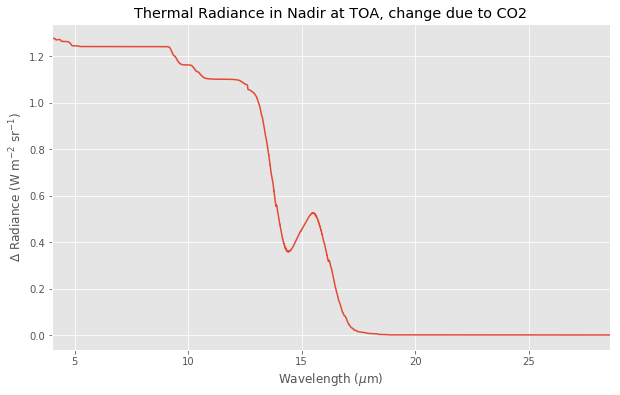

In [26]:
dwl = wl_nu[1:]*1e6-wl_nu[0:-1]*1e6

plt.plot(wl_nu[1:]*1e6,np.cumsum((TOA_dCO2[1:]-TOA[1:])*dwl),label='$\Delta$ in outgoing TOA radiance for CO2 doubling')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('$\Delta$ Radiance (W m$^{-2}$ sr$^{-1}$)')
plt.xlim((wl_nu[-1]*1e6,wl_nu[0]*1e6))
plt.title('Thermal Radiance in Nadir at TOA, change due to CO2')
print(np.sum((TOA_dCO2[1:]-TOA[1:])*dwl))

0.27668316504791035


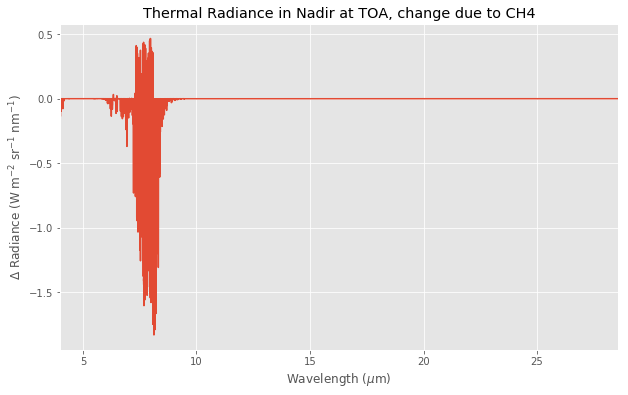

In [27]:
TOA_dCH4 = np.sum(R_dCH4,axis=1)+R_surfDCH4
plt.plot(wl_nu*1e6,TOA_dCH4-TOA,label='$\Delta$ in outgoing TOA radiance for CO2 doubling')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('$\Delta$ Radiance (W m$^{-2}$ sr$^{-1}$ nm$^{-1}$)')
plt.xlim((wl_nu[-1]*1e6,wl_nu[0]*1e6))
plt.title('Thermal Radiance in Nadir at TOA, change due to CH4')
print(np.sum((TOA_dCH4[1:]-TOA[1:])*dwl))

3.1545088413627944


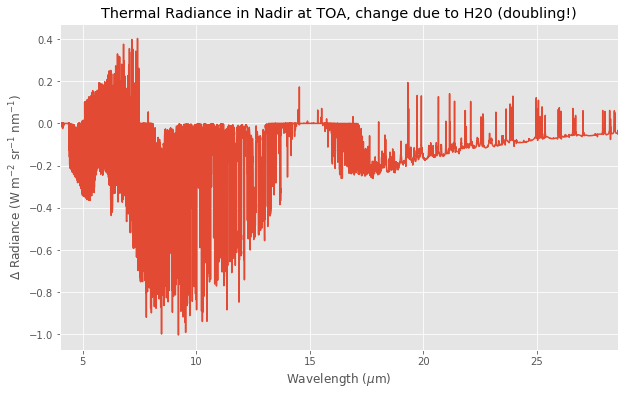

In [28]:
TOA_dH20 = np.sum(R_dH2O,axis=1)+R_surfDH2O
plt.plot(wl_nu*1e6,TOA_dH20-TOA,label='$\Delta$ in outgoing TOA radiance for CO2 doubling')
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('$\Delta$ Radiance (W m$^{-2}$ sr$^{-1}$ nm$^{-1}$)')
plt.xlim((wl_nu[-1]*1e6,wl_nu[0]*1e6))
plt.title('Thermal Radiance in Nadir at TOA, change due to H20 (doubling!)')
print(np.sum((TOA_dH20[1:]-TOA[1:])*dwl))

### Mean free path, where do the photons come from?
Let's compute the pressure where the optical density is about 1 (for each gas). At OD=1, we roughly have the mean free path of photons (i.e. at this pressure level, about half the photons actually reach the TOA).

In [29]:
Tau1 = np.zeros((len(nu_),))
Tau1_co2 = np.zeros((len(nu_),))
Tau1_h2o = np.zeros((len(nu_),))
Tau1_ch4 = np.zeros((len(nu_),))
TT_co2 = np.cumsum(tau_co2,axis=1)
TT_ch4 = np.cumsum(tau_ch4,axis=1)
TT_h2o = np.cumsum(tau_h2o,axis=1)
#plt.plot(p_full,TT_co2[4000,:])
#print(TT_co2.shape)
for i in range(len(nu_)):    
    Tau1_co2[i] = np.interp(1.0, TT_co2[i,:],p_full)
    Tau1_ch4[i] = np.interp(1.0, TT_ch4[i,:],p_full)
    Tau1_h2o[i] = np.interp(1.0, TT_h2o[i,:],p_full)
    Tau1[i] = np.interp(1.0, TT_h2o[i,:]+TT_ch4[i,:]+TT_co2[i,:],p_full)
#print(Tau1_co2[5000])


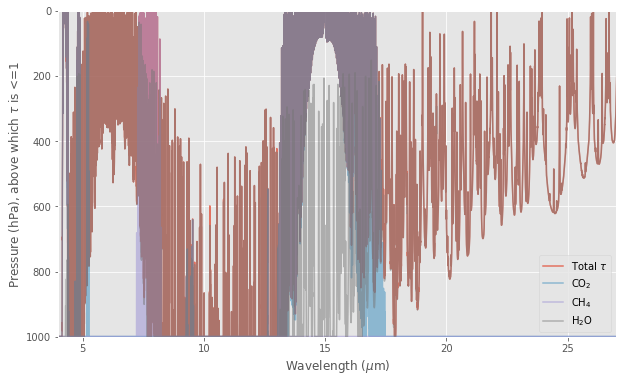

In [30]:
plt.plot(wl_nu*1e6,Tau1,label=r'Total $\tau$', alpha=0.75)
plt.plot(wl_nu*1e6,Tau1_co2,label='CO$_2$', alpha=0.5)
plt.plot(wl_nu*1e6,Tau1_ch4,label='CH$_4$', alpha=0.5)
plt.plot(wl_nu*1e6,Tau1_h2o,label='H$_2$O', alpha=0.5)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel(r'Pressure (hPa), above which $\tau$ is <=1')
plt.ylim((1000,0))
plt.xlim((4,27))
plt.legend(loc=0)

## Blackbody emission at the pressure level with mean free path=distance to TOA 
Now we can compute the Temperature and Blackbody emission from the pressure level at which the mean free path is equal to the distance to the TOA. This depends on wavelength of course...

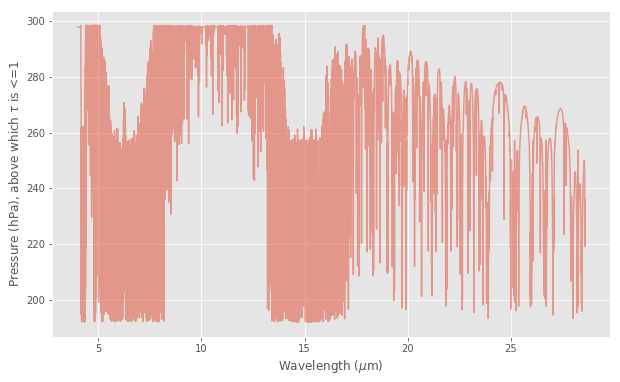

In [31]:
T_tau1 = np.interp(Tau1, p_full, T_local)
e_tau1 = np.zeros((len(T_tau1),))
for i in range(len(e_tau1)):
    e_tau1[i] = planck(wl_nu[i],T_tau1[i])
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel(r'Pressure (hPa), above which $\tau$ is <=1')
plt.plot(wl_nu*1e6,T_tau1,label='T', alpha=0.5)

Text(0.5,0,'Wavelength ($\\mu$m)')

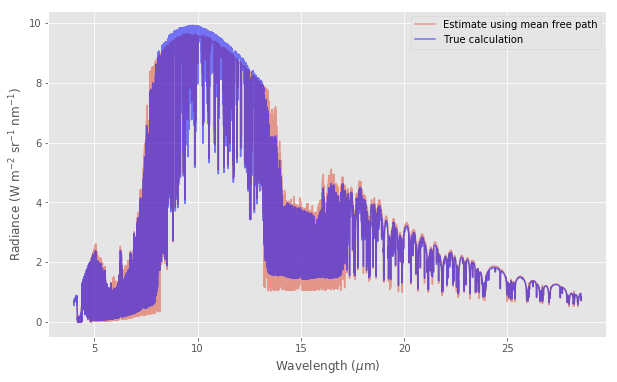

In [32]:
plt.plot(wl_nu*1e6,e_tau1,alpha=0.5, label='Estimate using mean free path')
plt.plot(wl_nu*1e6,np.sum(R[:,0:],axis=1)+R_surf,'b',alpha=0.5, label='True calculation')
plt.legend()
plt.ylabel('Radiance (W m$^{-2}$ sr$^{-1}$ nm$^{-1}$)')
plt.xlabel('Wavelength ($\mu$m)')

# TOA observations in Nadir separated by surface and atmospheric contributions

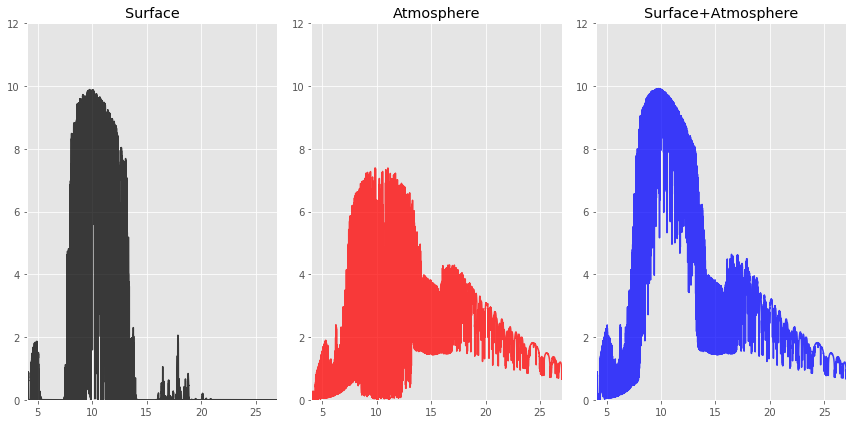

In [33]:
figsize(12,6)
plt.subplot(131)
plt.plot(wl_nu*1e6,R_surf,'k',alpha=0.75,label='Surface')
plt.title('Surface')
plt.xlim((4,27))
plt.ylim((0,12))
plt.subplot(132)
plt.plot(wl_nu*1e6,np.sum(R[:,0:],axis=1),'r',alpha=0.75, label='Atmosphere')
plt.title('Atmosphere')
plt.xlim((4,27))
plt.ylim((0,12))
plt.subplot(133)
plt.plot(wl_nu*1e6,np.sum(R[:,0:],axis=1)+R_surf,'b',alpha=0.75, label='Total')
plt.title('Surface+Atmosphere')
plt.xlim((4,27))
plt.ylim((0,12))
plt.tight_layout()

# Observations in Nadir through one atmospheric layer, separated by surface and atmospheric contributions
## Warmer surface than atmosphere

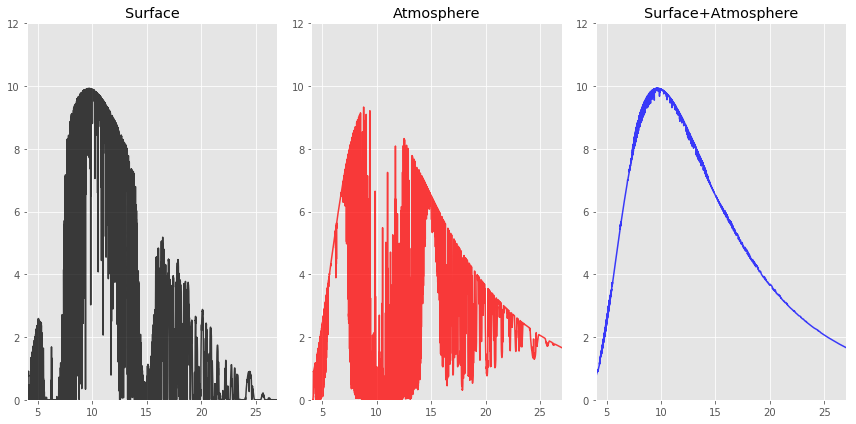

In [34]:
figsize(12,6)
plt.subplot(131)
plt.plot(wl_nu*1e6,B_surf*T[:,-1],'k',alpha=0.75,label='Surface')
plt.title('Surface')
plt.ylim((0,12))
plt.xlim((4,27))
plt.subplot(132)
plt.plot(wl_nu*1e6,B[:,-1]*(1-T[:,-1]),'r',alpha=0.75, label='Atmosphere')
plt.title('Atmosphere')
plt.ylim((0,12))
plt.xlim((4,27))
plt.subplot(133)
plt.plot(wl_nu*1e6,B_surf*T[:,-1]+B[:,-1]*(1-T[:,-1]),'b',alpha=0.75, label='Total')
plt.title('Surface+Atmosphere')
plt.ylim((0,12))
plt.xlim((4,27))
plt.tight_layout()

#plt.plot(wl_nu*1e6,B_surf*T[:,-1],wl_nu*1e6,B[:,-1]*(1-T[:,-1]),wl_nu*1e6,B_surf*T[:,-1]+B[:,-1]*(1-T[:,-1]))

## Colder surface than atmosphere

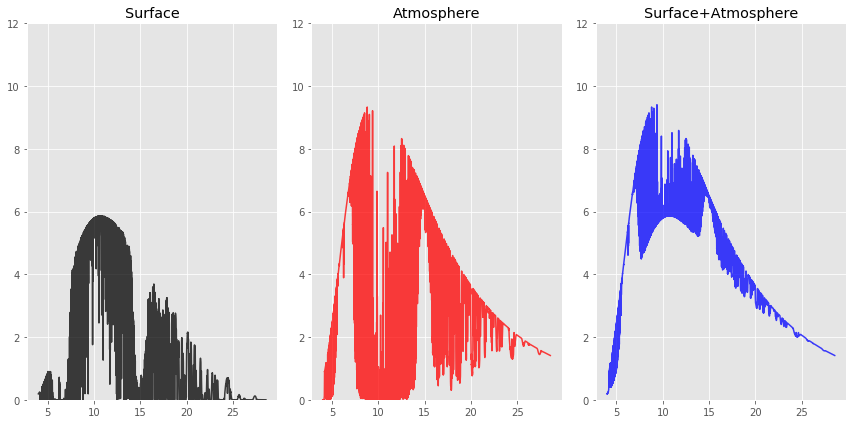

In [35]:
B_surf_270 = planck(wl_nu,270)

figsize(12,6)
plt.subplot(131)
plt.plot(wl_nu*1e6,B_surf_270*T[:,-1],'k',alpha=0.75,label='Surface')
plt.ylim((0,12))
plt.title('Surface')
plt.subplot(132)
plt.plot(wl_nu*1e6,B[:,-1]*(1-T[:,-1]),'r',alpha=0.75, label='Atmosphere')
plt.title('Atmosphere')
plt.ylim((0,12))
plt.subplot(133)
plt.plot(wl_nu*1e6,B_surf_270*T[:,-1]+B[:,-1]*(1-T[:,-1]),'b',alpha=0.75, label='Total')
plt.title('Surface+Atmosphere')
plt.ylim((0,12))
plt.tight_layout()

## No T gradient between surface and atmosphere
Resulting total just looks like a perfect blackbody! Any change in gas concentrations within this layer would have ZERO impact.

297.81555


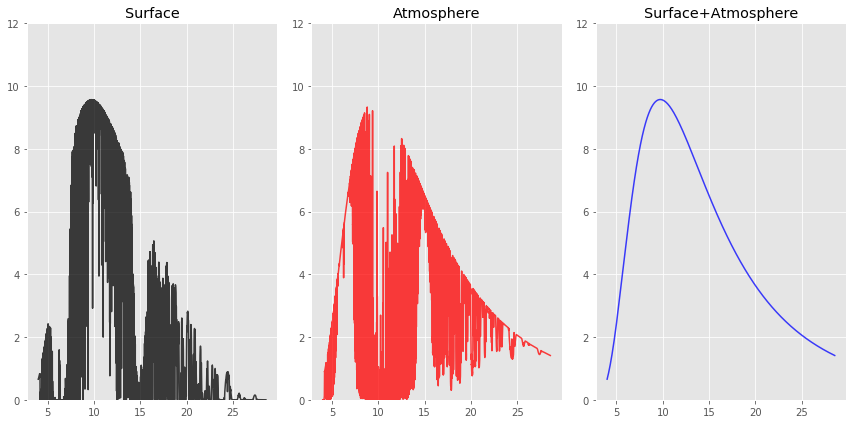

In [36]:
B_surf_270 = planck(wl_nu,T_local[-1])
print(T_local[-1])
figsize(12,6)
plt.subplot(131)
plt.plot(wl_nu*1e6,B_surf_270*T[:,-1],'k',alpha=0.75,label='Surface')
plt.ylim((0,12))
plt.title('Surface')
plt.subplot(132)
plt.plot(wl_nu*1e6,B[:,-1]*(1-T[:,-1]),'r',alpha=0.75, label='Atmosphere')
plt.title('Atmosphere')
plt.ylim((0,12))
plt.subplot(133)
plt.plot(wl_nu*1e6,B_surf_270*T[:,-1]+B[:,-1]*(1-T[:,-1]),'b',alpha=0.75, label='Total')
plt.title('Surface+Atmosphere')
plt.ylim((0,12))
plt.tight_layout()

### Now let us look at the downwelling radiation as well:


In [37]:
Rdown = np.zeros((len(nu_),NLEV))
Rdown_dCO2 = np.zeros((len(nu_),NLEV))
Rdown_dCH4 = np.zeros((len(nu_),NLEV))
Rdown_dH2O = np.zeros((len(nu_),NLEV))

for i in range(NLEV):
    Rdown[:,i] = B[:,i]*(1-T[:,i])*np.prod(T[:,i+1:],axis=1)
    Rdown_dCO2[:,i] = B[:,i]*(1-TdCO2[:,i])*np.prod(TdCO2[:,i+1:],axis=1)
    Rdown_dCH4[:,i] = B[:,i]*(1-TdCH4[:,i])*np.prod(TdCH4[:,i+1:],axis=1)
    Rdown_dH2O[:,i] = B[:,i]*(1-TdH2O[:,i])*np.prod(TdH2O[:,i+1:],axis=1)

In [38]:
Surface_Down = np.sum(Rdown,axis=1)
Surface_Down_dH2O = np.sum(Rdown_dH2O,axis=1)


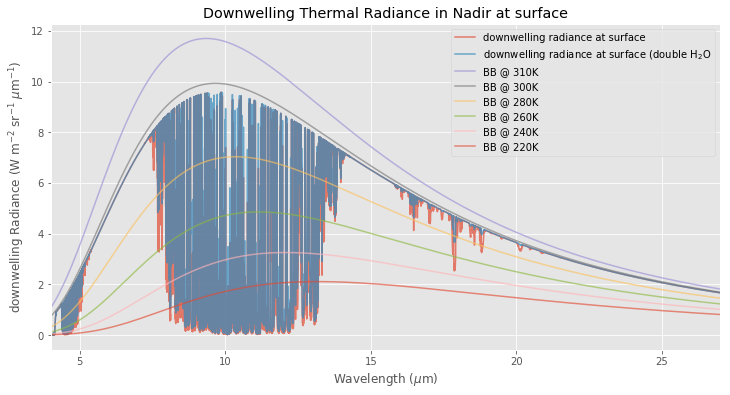

In [39]:
plt.plot(wl_nu*1e6,Surface_Down,label='downwelling radiance at surface', alpha=0.7)
plt.plot(wl_nu*1e6,Surface_Down_dH2O,label='downwelling radiance at surface (double H$_2$O', alpha=0.7)#, wl_nu*1e6, np.sum(R,axis=1), wl_nu*1e6,R_surf)
plt.plot(wl_nu*1e6, planck(wl_nu,310),label='BB @ 310K',alpha=0.63)
plt.plot(wl_nu*1e6, planck(wl_nu,300),label='BB @ 300K',alpha=0.63)
plt.plot(wl_nu*1e6, planck(wl_nu,280),label='BB @ 280K',alpha=0.63)
plt.plot(wl_nu*1e6, planck(wl_nu,260),label='BB @ 260K',alpha=0.63)
plt.plot(wl_nu*1e6, planck(wl_nu,240),label='BB @ 240K',alpha=0.63)
plt.plot(wl_nu*1e6, planck(wl_nu,220),label='BB @ 220K',alpha=0.63)
plt.legend(loc=0)
plt.xlabel('Wavelength ($\mu$m)')
plt.ylabel('downwelling Radiance (W m$^{-2}$ sr$^{-1}$ $\mu$m$^{-1}$)')
plt.xlim((4,27))
plt.title('Downwelling Thermal Radiance in Nadir at surface')
plt.savefig('ThermalSurfaceDown.pdf')

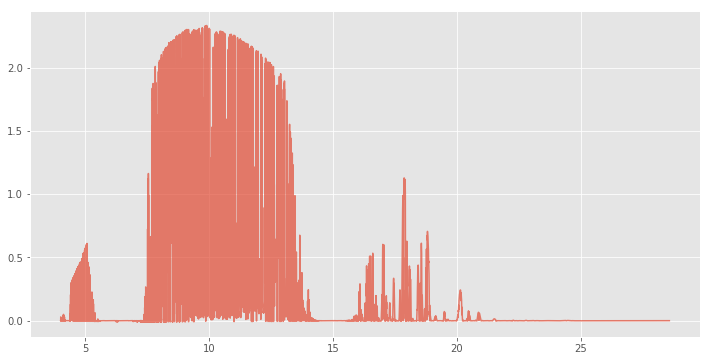

In [40]:
plt.plot(wl_nu*1e6,Surface_Down_dH2O-Surface_Down,label='downwelling radiance at surface', alpha=0.7)
#plt.plot(wl_nu*1e6,,label='downwelling radiance at surface (double H$_2$O', alpha=0.7)

In [41]:
print(np.sum((Surface_Down_dH2O[1:]-Surface_Down[1:])*dwl))

-4.131311887991318


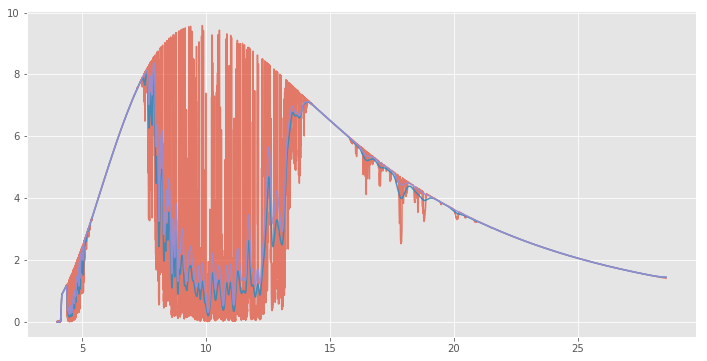

In [42]:
plt.plot(wl_nu*1e6,Surface_Down,label='downwelling radiance at surface', alpha=0.7)
plt.plot(wl_nu*1e6,gaussian_filter1d(Surface_Down,200),label='downwelling radiance at surface', alpha=0.9)
plt.plot(wl_nu*1e6,gaussian_filter1d(Surface_Down_dH2O,200),label='downwelling radiance at surface', alpha=0.9)

#### Play around with MODTRAN:
http://climatemodels.uchicago.edu/modtran/